In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import pickle
from functions_variables import *
from sklearn.linear_model import LogisticRegression

## Import final dataset

In [2]:
X_train = pd.read_csv('../data/final/X_train.csv')
X_test = pd.read_csv('../data/final/X_test.csv')

X_train_scaled = pd.read_csv('../data/final/X_train_scaled.csv')
X_test_scaled = pd.read_csv('../data/final/X_test_scaled.csv')
y_train = pd.read_csv('../data/final/y_train.csv')
y_test = pd.read_csv('../data/final/y_test.csv')

### Get predicted values to be used for backtesting

In [ ]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

### Import the same scaler used to scale the data originally so I can unscale them properly

In [4]:
with open('../data/final/scalar.pkl', 'rb') as f:
    scaler = pickle.load(f)
    
# Unscale the data back to its original scale
X_test_unscaled = scaler.inverse_transform(X_test_scaled)

# Convert back to a DataFrame if needed
X_test_unscaled_df = pd.DataFrame(X_test_unscaled, columns=X_test_scaled.columns)

### Unscaled data results in the same as X_test and will be used for back testing

In [ ]:
df = X_test_unscaled_df[['TSX']]
df.loc[:, 'Predict'] = y_pred

### Initialize Values

<p>Set initial seed of $1M and zero shares of the TSX. The TSX is an index, so you can't really trade, except through an ETF, which is why I started with a seed investment of $1M since the index starts at 20,795.</p>

In [ ]:
# $1,000,000
investment = 1000000
shares = 0
expected_return = 0.05 # 5% expected return on investments

# Initialize columns
df['Cummulative Investment'] = 0
df['Shares Held'] = 0
df['Action'] = ''
df['Buy'] = 0

## Back Testing

#### Trading Strategy 1 - Dollar Cost Averaging
<p>The trading strategy employed for this model is to do the following:</p>

- If the model predicts the index will go down - Purchase one share
- If the model predicts the index will go up:
    - Sell all shares if the shares held have an average price below the current close price
    - Hold if no shares held or average price is above current close price

<p>Iterate over TSX value and prediction to calculate the appropriate trade, cummulative investment, trade action, shares held using a custom built trade function</p>

In [ ]:
for index, row in df.iterrows():
    if index > 0:  # Ensure there is a prior row
        open = df.loc[index - 1, 'TSX'] 
        investment, shares, action, avg = trade_DCA(open, row['TSX'], index, df, shares, investment, row['Predict'], expected_return)
        df.loc[index, 'Cummulative Investment'] = investment 
        df.loc[index, 'Shares Held'] = shares 
        df.loc[index, 'Action'] = action 
        df.loc[index, 'Average Price'] = avg
        if action == 'buy':
            df.loc[index, 'Buy'] = row['TSX']

In [8]:
df.head(15)

,TSX,Predict,Cummulative Investment,Shares Held,Action,Buy,Buy_Shifted,Average Price
0,20520.60,False,0.00,0,,0.00,NaN,NaN
1,20518.07,False,979469.40,1,buy,20518.07,0.00,NaN
2,20483.42,False,958941.33,2,buy,20483.42,20518.07,20518.070000
3,20363.59,False,938447.91,3,buy,20363.59,20483.42,20500.745000
4,20302.11,False,918074.32,4,buy,20302.11,20363.59,20455.026667
5,20215.36,False,897762.21,5,buy,20215.36,20302.11,20416.797500
6,20339.02,True,897762.21,5,hold,0.00,20215.36,20376.510000
7,20477.26,True,897762.21,5,hold,0.00,0.00,20376.510000
8,20547.76,True,897762.21,5,hold,0.00,0.00,20376.510000
9,20587.32,True,897762.21,5,hold,0.00,0.00,20376.510000


In [ ]:
num_trading_days = 252
num_days_test_set = df.shape[0]
initial_investment = 1000000

total_return = df['Cummulative Investment'].iloc[-1] - initial_investment
final_position = df['Shares Held'].iloc[-1] * df['TSX'].iloc[-1]

total_return = total_return + final_position
total_per_return = total_return / initial_investment * 100
annualized_per_return = ((1 + total_per_return/100) ** (num_trading_days / num_days_test_set) - 1)*100

print(f'Total gain for backtested prediction on test set was {total_return:,.2f}')
print(f"Total % return is: {(total_per_return):.2f}%")
print(f"Total annualized % return is: {(annualized_per_return):.2f}%")

- Total gain for backtested prediction on test set was 129,312.80. This strategy only works if the price goes above the average cost, otherwise the investor will continually buy, which can be seen in the graph of cummulative investment. The index will eventually go up, but as an investor you would have to put a lot of money in and potentially wait a long time for a return.
- Total % return is: 12.93%
- Total annualized % return is: 4.74%


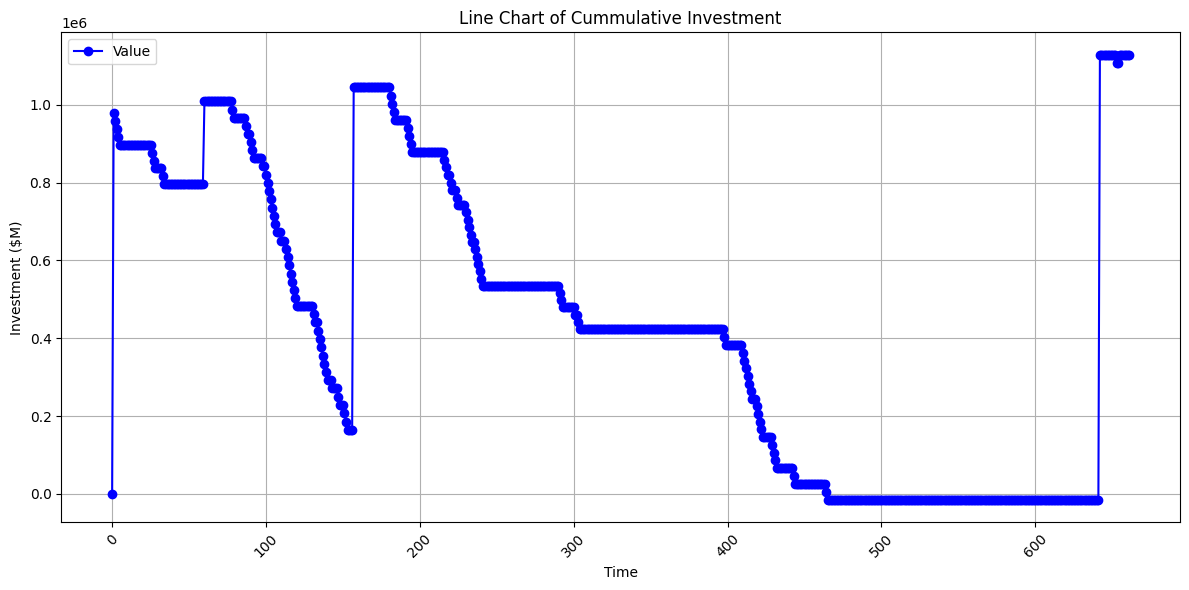

In [10]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(df.index, df['Cummulative Investment'], marker='o', linestyle='-', color='b', label='Value')  # Plot the line chart

# Customize the plot
plt.title('Line Chart of Cummulative Investment')  # Set the title
plt.xlabel('Time')  # Label for x-axis
plt.ylabel('Investment ($M)')  # Label for y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust the padding between and around subplots

#### Trading Strategy 2 - Invest All
<p>The trading strategy employed for this model is to do the following:</p>

- If the model predicts the index will go down - do nothing
- If the model predicts the index will go up:
    - If we already hold shares and the average cost is below the open price sell all the shares
    - Use the entire investment to purchase all shares at the open price
    - If the close price is greater than the open price we purchased at, sell all the shares
    - If the close price is less than the open price hold the shares to another day

In [ ]:
for index, row in df.iterrows():
    if index > 0:  # Ensure there is a prior row
        open = df.loc[index - 1, 'TSX'] 
        investment, shares, action, avg = trade_purchase(open, row['TSX'], index, df, shares, investment, row['Predict'])
        df.loc[index, 'Cummulative Investment'] = investment 
        df.loc[index, 'Shares Held'] = shares 
        df.loc[index, 'Action'] = action 
        df.loc[index, 'Average Price'] = avg
        if action == 'hold':
            df.loc[index, 'Buy'] = row['TSX']

In [12]:
df.head(15) # ensure that the trade function is calclating everything correctly. All Good!!

,TSX,Predict,Cummulative Investment,Shares Held,Action,Buy,Buy_Shifted,Average Price
0,20520.60,False,0.00,0,,0.00,NaN,NaN
1,20518.07,False,1129312.80,0,hold,20518.07,0.00,20145.768476
2,20483.42,False,1129312.80,0,hold,20483.42,20518.07,20145.768476
3,20363.59,False,1129312.80,0,hold,20363.59,20483.42,20145.768476
4,20302.11,False,1129312.80,0,hold,20302.11,20363.59,20145.768476
5,20215.36,False,1129312.80,0,hold,20215.36,20302.11,20145.768476
6,20339.02,True,1136094.10,0,sell,0.00,20215.36,0.000000
7,20477.26,True,1143677.30,0,sell,0.00,0.00,0.000000
8,20547.76,True,1147534.80,0,sell,0.00,0.00,0.000000
9,20587.32,True,1149690.60,0,sell,0.00,0.00,0.000000


In [ ]:
num_trading_days = 252
num_days_test_set = df.shape[0]
initial_investment = 1000000

total_return = df['Cummulative Investment'].iloc[-1] - initial_investment
final_position = df['Shares Held'].iloc[-1] * df['TSX'].iloc[-1]

total_return = total_return + final_position
total_per_return = total_return / initial_investment * 100
annualized_per_return = ((1 + total_per_return/100) ** (num_trading_days / num_days_test_set) - 1)*100

print(f'Total gain for backtested prediction on test set was {total_return:,.2f}')
print(f"Total % return is: {(total_per_return):.2f}%")
print(f"Total annualized % return is: {(annualized_per_return):.2f}%")

- Total gain for backtested prediction on test set was 1,243,698.69
- Total % return is: 124.37%
- Total annualized % return is: 36.02%



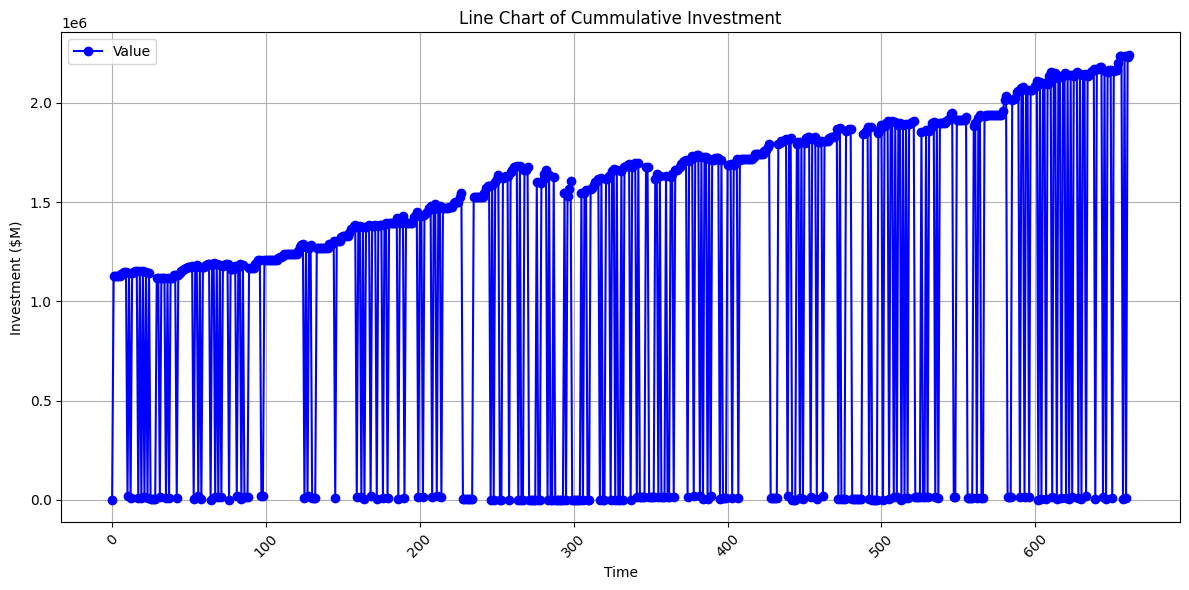

In [14]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(df.index, df['Cummulative Investment'], marker='o', linestyle='-', color='b', label='Value')  # Plot the line chart

# Customize the plot
plt.title('Line Chart of Cummulative Investment')  # Set the title
plt.xlabel('Time')  # Label for x-axis
plt.ylabel('Investment ($M)')  # Label for y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust the padding between and around subplots